**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2020

# NuScale 720 SMR BoP Simulation Final Report
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Students:** Jack and Nik <br>
**Course:** Engy-4390 Nuclear Systems Design and Analysis  <br>
**Mentor:** Prof. Valmor F. de Almeida

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**11Dec2020**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Objectives](#obj)
* [Input Data](#data)
* [Steady state](#ss)

* [Function library](#flib)
 + [Reactor](#reactor)
   - [One-Group Energy Neutron Balance](#nbal)

 + [Steam Generator](#steamgen)
 + [Turbine](#turbine)
 + [Condenser](#condenser)
 + [Coupling](#coupling)
    - [Vector ODE System](#vodes)
* [Startup: Reactivity Step with Negative Feedback Results](#res1)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

Introduction?


## [Objectives](#toc)<a id="obj"></a>

Objectives?

## [Input Data](#toc)<a id="data"></a>

Data pertaining to one-group energy neutron balance. 

Name                        | Parameter     | Value                | Unit             |
----------------------------|---------------|----------------------|------------------| 
neutron generation time                           | $\ell$             | $1\times 10^{-4}$    |  s | 
delayed neutron fraction                          | $\beta$            | $6.5\times 10^{-3}$  |  - |
neutron diffusion coeff.                          | $D$                | $0.84$              | cm |
core radius                                       | $R$                | $1.8\times 10^{2}$  | cm  |
core height                                       | $H$                | $2.8\times 10^{2}$  | cm  |
infinite medium neutron reproduction factor       | $k_\infty$ | 1.118 | - |
graphite effective macroscopic absorption cross section ref. | $\overline{\Sigma}_\text{a}^\text{(o)} $ | $2.74\times 10^{-4}$ |  cm$^{-1}$ |
other quantities; possibly microscopic cross sections | . | . |
. | . | . |

For thermal fission of $^{235}$U the following six-group delayed neutron precursors data is typically used (*Physics of Nuclear Kinetics*, G. R. Keepin, 1965, Addison-Wesley Pub. Co.):


Delayed neutron emitter group No. | Decay cte ($\lambda_i$,1/sec) | Relative yield ($\beta_i/\beta$) |
----------------------------------|-------------------------------|----------------------------------| 
1                                 | 0.0124                        | 0.033                            |
2                                 | 0.0305                        | 0.219                            | 
3                                 | 0.111                         | 0.196                            |  
4                                 | 0.301                         | 0.395                            | 
5                                 | 1.14                          | 0.115                            |
6                                 | 3.01                          | 0.042                            |

Data pertaining to two-temperature heat balances.

Name                        | Parameter     | Value                | Unit             |
----------------------------|---------------|----------------------|------------------| 
fission energy per fission                        | $G_\text{f}$  | 180               | MeV/fission |
$^{235}$U fuel enrichment                         | $\epsilon$ | 3 | wt% |
UO$_2$ fuel material mass density                 | $\rho_\text{fm}$ | 10.5 | g/cc |
moderator-fuel ratio (atomic number concentration) | $N^{M}/N^{U}$ | 387 |
$^{235}$U thermal microscopic fission cross section | $\sigma_{\text{f}_\text{o}}$ | 586.2 | barn |
thermal neutron temperature                       | $T^{(\text{o})}$ | 20 | C |
thermal neutron velocity                          | $v_\text{(o)}$     | 2200 | m/s |
heat transport coeff. | . | . | . |
fuel/moderator heat capacity | . | . | . |
coolant heat capacity | . | . | . |
fuel/moderator mass density | . | . | . |
coolant mass density | . | . | . |
moderator/fuel volume | . | . | . |
coolant volume | . | . | . |
coolant flow rate | . | . | . |

The residence time of the coolant in the core

\begin{equation*}
\tau = V_c / q_c
\end{equation*}


In [5]:
##### '''Parameters'''

import scipy.constants as unit # for unit conversion
unit.second = 1.0
unit.pascal = 1.0
unit.meter = 1.0

import math

params = dict()

#Data pertaining to one-group energy neutron balance
params['gen_time']     = 1.0e-4  # s
params['beta']         = 6.5e-3  # 
params['diff_coeff']   = 0.84 # cm
#params['core radius']  = 1.8e+2 # cm
#arams['core_height']  = 2.8e+2 # cm
params['k_infty']      = 1.49826
params['buckling'] = 1.538e-4
#params['Sigma_a']      = 2.74e-4 # 1/cm

params['alpha_n'] = -3e-6 # control rod reactivity worth
#params['alpha_tn_fake'] = -1e-6 # temperature reactivity feedback

params['n_dens_ss_operation'] = 5e14/2200 #  #neutrons/m^2

#Delayed neutron emission
params['species_decay']     = [0.0124, 0.0305, 0.111, 0.301, 1.14, 3.01] # 1/sec
params['species_rel_yield'] = [0.033, 0.219, 0.196, 0.395, 0.115, 0.042] 

#Data pertaining to two-temperature heat balances
params['fis_energy']           = 180 * 1.602e-13 # J/fission 
params['enrich']               = 5/100.
params['fuel_mat_mass_dens']   = 10.8 # g/cc
#params['moderator_fuel_ratio'] = 387 # atomic number concentration ratio
params['sigma_f_o']            = 586.2 * 100 * 1e-30 # m2
params['temp_o']               =  20 + 273.15 # K
params['temp_f_0'] = 20 + 273.15 
params['temp_c_ss_operation']  = 265 + 273.15# K desired ss operation temp of coolant
params['thermal_neutron_velo'] = 2200 # m/s

params['fis_nuclide_num_dens_fake'] = 9.84e26 # (fissile nuclei)/m3
params['sg_efficiency'] =  0.79194
params['mdot_secondary'] = 67.06867 # kg/s
params['condenser_pressure'] =  0.008066866 #MPa
params['coolant_flowrate'] = 666 #kg/s
params['temp_inlet_ss'] = 265+273.15
params['q_c'] = .89755 # volumetric flow rate

params['fuel_dens']   = 10800 # kg/m3
params['cp_fuel']     = 300 # J/(kg K)
params['fuel_volume'] = .8565 # m3
params['coolant_vol_flow'] = 0.995174404072919 # m3/s
params['coolant_dens']   = 669.2294308156266 #  kg/m3
params['cp_coolant']     =  1000*5.382268683703659# J/(mol K) - > J/(kg K)
params['coolant_volume'] = 2.8 # m3

params['ht_coeff'] = 466459.62 # W/K
params['tau_hx'] =  5*unit.minute 
params['m2'] = 28.44

params['Turbine_Efficiency'] = 0.778443953538741

## [Steady State](#toc)<a id="ss"></a>

Neutron density and delayed neutron precursor concentrations are related as follows:

\begin{align*}
n_\text{ss}  &= -\frac{q_\text{ss}\,\ell }{\rho_\text{ss} }
\\
c_{i_\text{ss}}  &= \frac{\beta_i}{\lambda_i\,\ell}\, n_\text{ss}   \ \ \ \ \forall \ \ \ \ i=1,\ldots,6 .
\end{align*}

In [6]:
'''Setup function for delayed neutron species concentrations at steady state'''

def setup_initial_conditions(params):
    
    # setup the steady state for the delayed-neutron precursors
    
    n_species = len(params['species_decay'])
    
    assert len(params['species_rel_yield']) == n_species
    
    import numpy as np
    c_vec_0 = np.zeros(n_species,dtype=np.float64) # initialize conentration vector

    species_decay = params['species_decay'] # retrieve list of decay constants
    lambda_vec    = np.array(species_decay) # create a numpy vector

    species_rel_yield = params['species_rel_yield']
    beta_vec = np.array(species_rel_yield) * beta  # create the beta_i's vector

    gen_time = params['gen_time'] # retrieve neutron generation time

    n_ss = params['n_ss']
    c_vec_ss = beta_vec/lambda_vec/gen_time * n_ss # compute the steady state precursors number density
    
    params['c_vec_ss'] = c_vec_ss
    
    # setup initial condition for variables
    params['n_0']     = n_ss
    params['c_vec_0'] = c_vec_ss
    params['rho_0']   = params['reactivity']
    
    #params['temp_f_0'] = params['temp_0']
    #params['temp_c_0'] = params['temp_0']
    params['temp_c_0'] = 25 + 273.15
    return

## [Function Library](#toc) <a id="flib"></a>

Functions used later in the notebook.

### [Reactor](#toc)<a id="reactor"></a>

#### [One-Group Energy  Neutron Balance](#toc)<a id="nbal"></a>

The space-invariant neutron balance for the point-reactor model is

\begin{equation*}
\frac{\text{d}n}{\text{d}t}  = \frac{\rho(t)-\beta}{\ell}\, n + \sum\limits_{i=1}^{6} \lambda_i\,c_i  + q(t),
\end{equation*}

where the first term on the right side of the equation represents the net production of neutrons not accounting for delayed neutrons, and the second term accounts for the source of delayed neutrons considering 6 groups of delayed neutron emitters resulting from the fission of $^{235}$U nuclei. Therefore a balance of neutron emitter species is also necessary

\begin{equation*}
\frac{\text{d}c_i}{\text{d}t}  = \frac{\beta_i}{\ell}\, n - \lambda_i\,c_i ,
     \ \ \ \ \ \forall \ \ \ \ \  i=1,\ldots,6.
\end{equation*}

where the first term on the right side of the equation is the source of emitters as a function of the neutron number density $n(t)$, and the second term is the consumption rate of the emitter by radioactive decay obtained as a function of the product of the number concentration of the emmiter, $c_i(t)$, multiplied by its decay constant $\lambda_i$. Here the number concentration of of the $i$th emitter, $c_i$ is considered in terms of delayed neutron number density, hence the units are the same as $n$.

The current model considers the temperature reactivity coefficient, $\alpha_{T_n}$, that is, 

\begin{equation*}
 \rho(t) = \rho_0 + \alpha_\text{n} \,\bigl(n(t) - n_\text{ref} \bigr) + \alpha_{T_n}(\overline{T})\,\bigl(\overline{T}(t) - T_\text{ref} \bigr),
\end{equation*}

where basic nuclear effects are taking into account through the sub-model

\begin{equation*}
 \alpha_{T_n}(T) = - \frac{B^2\,D}{2\,k_\infty\,\overline{\Sigma}_a^{(\text{o})}\,\sqrt{T^\text{(o)}\,T}}.
\end{equation*}

A heat balance in the static fuel dispersed into the moderator gives

\begin{equation*}
\frac{\text{d}T_f}{\text{d}t} = - \frac{1}{\rho_f\,c_{pf}}\biggl(q^{'''}(t) - \frac{\dot{Q}_\text{f}}{V_f} \biggr) 
\end{equation*}

where the heat rate sink in the fuel/moderator is 

\begin{equation*}
{\dot{Q}_\text{f}} = -UA\bigl(T_f-T_c\bigr), 
\end{equation*}

and the nuclear heating power is given by

\begin{equation*}
q^{'''}(t) = G_f\frac{\sqrt{\pi}}{2}\,\sigma_\text{fo}\,\sqrt{\frac{T^\text{(o)}}{T}}\,\biggl(\frac{\epsilon\,w_\text{fs}\,\rho_\text{fm}}{M_\text{fn}}\,i\,N_A\biggr)\,n(t)\,v_\text{(o)} .
\end{equation*}

A heat balance in the flowing coolant fluid produces

\begin{equation*}
\frac{\text{d}T_c}{\text{d}t} = -\frac{1}{\tau_c}\biggl(T_c-T_{in}\biggr)  
                                - \frac{1}{\rho_c\,c_{pc}}\biggl( \frac{\dot{Q}_\text{f}}{V_c} \biggr) 
\end{equation*}

where the heat rate source is the negative of the heat rate sink in the fuel/moderator.

Reactivity coefficient based on nuclear effects through the sub-model

\begin{equation*}
 \alpha_{T_n}(T) = - \frac{B^2\,D}{2\,k_\infty\,\overline{\Sigma}_a^{(\text{o})}\,\sqrt{T^\text{(o)}\,T}}.
\end{equation*}

In [7]:
'''Reactivity coefficient function'''


def alpha_tn_func(temp):
    '''
    Place holder for implementation
    '''

    B2 = params['buckling']
    D = params['diff_coeff']
    k_infty = params['k_infty']
    Ea = .9822  #/cm
    To = 20 + 273.15
    alpha_tn = -1 / 2 * B2 * D / (k_infty * Ea * math.sqrt(To * temp))

    return alpha_tn

In [8]:
'''Reactivity function'''

def rho_func( t, n_dens, temp, params ):
    '''
    Reactivity function.  
    
    Parameters
    ----------
    t: float, required
        Time.
    temp_f: float, required
        Temperature at time t.
    params: dict, required
        Dictionary of quantities. It must have a `'rho_0'` key/value pair.
    
    Returns
    -------
    rho_t: float
        Value of reactivity.

    Examples
    --------
    '''
    
    rho_0  = params['rho_0']
    temp_ref = params['temp_c_ss_operation']
    alpha_n = params['alpha_n']
    n_dens_ref = params['n_dens_ref']
    
    alpha_tn = alpha_tn_func(temp)
    
    rho_t = rho_0 + alpha_n * (n_dens - n_dens_ref) + alpha_tn * (temp - temp_ref)
    
        
    return rho_t

In [9]:
'''Source function'''

def q_source( t, params ):
    '''
    Neutron source delta function.  
    
    Parameters
    ----------
    t: float, required
        Time.
    params: dict, required
        Dictionary of quantities. It must have a `'q_0'` key/value pair.
    
    Returns
    -------
    q: float
        Value of source.

    Examples
    --------
    '''
    
    q = 0
    q_0 = params['q_0']
    
    if t <= 100*unit.milli*unit.second: # small time value
        q = q_0
    else:
        q = 0.0
        
    return q

#print("done")

The effective fission microscopic cross section for thermal neutrons will be taken as:

\begin{equation*}
\overline{\sigma}_\text{f}(T) = \frac{\sqrt{\pi}}{2}\,\sigma_\text{fo}\,\sqrt{\frac{T^\text{(o)}}{T}}
\end{equation*}

In [10]:
'''Effective microscopic fission cross section'''

def sigma_fis_func( temp, params ):
    '''
    Place holder for implementation
    '''
    
    sigma_f = params['sigma_f_o'] * math.sqrt(298/temp) * math.sqrt(math.pi)/2.0
    
    return sigma_f

The nuclear heating power is given by

\begin{equation*}
q^{'''}(t) = G_f\,\overline{\sigma}_\text{f}(T)\,N_\text{fn} \,\varphi(t) .
\end{equation*}

In [11]:
'''Nuclear power density function'''

def nuclear_pwr_dens_func( time, temp, n_dens, params ):
    '''
    Place holder for implementation
    '''
    
    rxn_heat = params['fis_energy'] # get fission reaction energy J per reaction
    
    sigma_f = sigma_fis_func( temp, params ) # m2
    
    fis_nuclide_num_dens = params['fis_nuclide_num_dens_fake'] #  #/m3
    
    Sigma_fis = sigma_f * fis_nuclide_num_dens # macroscopic cross section
    
    v_o = params['thermal_neutron_velo'] # m/s
    
    neutron_flux = n_dens * params['n_dens_ss_operation'] * v_o
    
    #reaction rate density
    rxn_rate_dens = Sigma_fis * neutron_flux
    
    # nuclear power source
    q3prime = - rxn_heat * rxn_rate_dens # exothermic reaction W/m3
    
    return q3prime

The cooling heat rate is:

\begin{equation*}
{\dot{Q}_\text{f}} = -UA\bigl(T_f-T_c\bigr). 
\end{equation*}

In [12]:
'''Cooling heat rate'''

def heat_sink_rate( time, temp_f, temp_c, params):
    
    ht_coeff = params['ht_coeff']
    
    q_f = - ht_coeff * (temp_f - temp_c)
    
    return q_f

### [Steam Generator](#toc)<a id="steamgen"></a>

The power removed from the core by the coolant is given by the folowing equation:

\begin{equation}
\dot{\mathrm{Q}}=\dot{\mathrm{m}} \mathrm{C}_{\mathrm{p}} \Delta \mathrm{T}
\end{equation}

Where $
\dot{\mathrm{Q}}
$ is the heat removed per unit time,  $
\dot{\mathrm{m}}
$ is the mass flow rate of coolant, $\mathrm{C}_{\mathrm{p}}$ is the constant pressure heat capacity of the coolant, and $\Delta \mathrm{T}$ is the primary side temperature difference.

The power attributed to heating the secondary stream is given by:

\begin{equation}
\dot{\mathrm{m}}_{2}\left(\mathrm{h}_{2}-\mathrm{h}_{1}\right)
\end{equation}

Where $ \dot{\mathrm{m}}_{2} $ is the mass flow rate of the secondary side, $\mathrm{h}_{1}$ is the specific enthalpy of the secondary side stream entering the steam generator, and  $\mathrm{h}_{2}$ is the specific enthalpy of the secondary sidde stream exiting the steam generator. 

As the primary side is heating the secondary side the power equations must equal:

\begin{equation*}
\dot{Q}=\dot{m}_1 C_P\Delta T=\frac{\dot{m}_2(h_2-h_1)}{\eta}
\end{equation*}


\begin{equation*}
d_tT_\text{in} = - \frac{1}{\tau_\text{hx}}\bigl(T_\text{in} - T^\text{(o)}\bigr) .
\end{equation*}

In [13]:
'''Steam generator module'''
import iapws.iapws97 as steam_table
def steam_generator_primary_outflow_temp(time, primary_inflow_temp, params):
    '''
    t_ss = primary_inflow_temp - m_dot_2*(h_out-h_in)/(m_dot_1*cp_primary*eta_sg)
        
    if t_ss >= 0:
        primary_outflow_temp = t_ss + math.exp(-time/params['tau_hx']) * (primary_inflow_temp-t_ss)
    else:
        primary_outflow_temp = primary_inflow_temp
    '''
    m_dot_1 = params['coolant_flowrate']
    m_dot_2 = params['mdot_secondary']
    eta_sg = params['sg_efficiency']
    t_ss = params['temp_inlet_ss']
    t_0 = params['temp_c_0']

    primary_outflow_temp = t_ss + math.exp(-time / params['tau_hx']) * (
        (t_0) - t_ss)  #relaxation

    cp_primary = steam_table._Region1(
        (primary_outflow_temp + primary_inflow_temp) / 2,
        12.8)["cp"]  #Cp of primary from avg inlet/outlet
    q = m_dot_1 * (primary_inflow_temp -
                   primary_outflow_temp) * cp_primary  #heat lost to SG
    p_out_sg = 3.3977364 + math.exp(-time / params['tau_hx']) * (
        (3.5190841) - 3.3977364)
    h_1_sg = steam_table._Region1(148.89 + 273.15, 3.5190841)['h']
    h_2_sg = (eta_sg * q / m_dot_2) + h_1_sg
    bubl = steam_table._Region4(p_out_sg, 0)
    dew = steam_table._Region4(p_out_sg, 1)
    bubl_entropy = bubl['s']
    dew_entropy = dew['s']
    bubl_enthalpy = bubl['h']
    dew_enthalpy = dew['h']

    if h_2_sg < bubl_enthalpy:
        t_exit_sg = steam_table._Backward1_T_Ph(p_out_sg, h_2_sg)
        return primary_outflow_temp, t_exit_sg, p_out_sg

    # if fluid exiting sg is superheated
    if h_2_sg > dew_enthalpy:
        t_exit_sg = steam_table._Backward2_T_Ph(p_out_sg, h_2_sg)
        #print('super heated')
        return primary_outflow_temp, t_exit_sg, p_out_sg
    # else fluid is two phase
    t_exit_sg = steam_table._TSat_P(p_out_sg)

    return primary_outflow_temp, t_exit_sg, p_out_sg

### [Turbine](#toc)<a id="turbine"></a>

In [14]:
''' Turbine Function '''
def turbine_func( time,p_in, p_out, temp_in, params):
    'p_out: Condenser pressure / turbine step pressure [MPa]'
    'temp_out: Condenser temperature / turbine step temperature [C]'
    'temp_in: Steam temp entering turbine [K]'
    turbine_efficiency = params['Turbine_Efficiency']
    m_dot_2 = params['mdot_secondary']
    
    #if entering stream is not steam (valve closed scenario)
    if temp_in < steam_table._TSat_P(p_in):
            t_runoff = steam_table._TSat_P(p_in)
            power = 0
            quality = 0
            return power, quality, t_runoff
    
    s_2_prime = steam_table._Region2(temp_in, p_in)['s']
    h_1 = steam_table._Region2(temp_in, p_in)['h']
    bubl = steam_table._Region4(p_out, 0) 
    dew = steam_table._Region4(p_out, 1)
    bubl_entropy = bubl['s']
    dew_entropy = dew['s']
    bubl_enthalpy = bubl['h']
    dew_enthalpy = dew['h']
        

    #if the ideal runoff is two-phase mixture: 
    if  bubl_entropy < s_2_prime < dew_entropy:
        
        quality = (s_2_prime - bubl_entropy)/(dew_entropy - bubl_entropy)
          
        #h_2_prime = steam_table._Region4(p_out, quality)['h']
        h_2_prime = bubl_enthalpy + quality*(dew_enthalpy-bubl_enthalpy)
   #if run off is superheated
    elif  s_2_prime > dew_entropy:
            
        t_ideal = steam_table._Backward2_T_Ps(p_out,  s_2_prime)
           
        h_2_prime = steam_table._Region2(t_ideal, p_out)['h']
        quality = 1
    #else run off is subcooled
    else:
        t_ideal = steam_table._Backward1_T_Ps(p_out,  s_2_prime)
           
        h_2_prime = steam_table._Region1(t_ideal, p_out)['h']
        quality = 0   
    
    t_runoff = steam_table._TSat_P(p_out)
    #print('h2 = ',h_2_prime)
    #calculate the real runoff enthalpy
    w_ideal = h_1 - h_2_prime #on a per mass basis
    assert(w_ideal > 0)
    w_real = w_ideal * turbine_efficiency
    h_real = h_1 - w_ideal
    assert h_real > 0
    if w_real < 0:
            w_real = 0

  

    #if the real runoff is a subcooled liquid
    if h_real < bubl_enthalpy:
        t_runoff = steam_table._Backward1_T_Ph(p_out, h_real)
        quality = 0 # subcooled liquid
    
    power = m_dot_2 *(w_real)
    return power, quality, t_runoff

### [Condenser](#toc)<a id="condenser"></a>

In [15]:
def condenser_func(time,t_in, x_in, params):
    return null

### [Coupling](#toc)<a id="coupling"></a>

### [Vector ODE System](#toc)<a id="vodes"></a>

A vector notation for the foregoing system of equations greatly improves the generality of the derived computer code. Towards this goal let us define

\begin{equation*}
\frac{d\uvar}{dt} = \fvar( \uvar, t )
\end{equation*}

where $\uvar(t) = (u_1,u_2,u_3,u_4,u_5,u_6,u_7)$ is the state vector and we assign 

\begin{align*}
 u_1(t)&=n(t),\\
 u_2(t)&=c_1(t),\\
 u_3(t)&=c_2(t),\\
 u_4(t)&=c_3(t),\\
 u_5(t)&=c_4(t),\\
 u_6(t)&=c_5(t),\\
 u_7(t)&=c_6(t),\\
 u_8(t)&=T_f(t),\\
 u_9(t)&=T_c(t).
\end{align*}

Also for $\fvar(\uvar,t) = \bigl(f_1(\uvar,t), f_2(\uvar,t), f_3(\uvar,t), f_4(\uvar,t), f_5(\uvar,t), f_6(\uvar,t), f_7(\uvar,t)\bigr)$ we assign 

\begin{align*}
 f_1 & = \frac{\rho(t)-\beta}{\ell}\, u_1 + \sum\limits_{i=2}^{7} \lambda_i\,u_i + q(t), \\
 f_2 & = \frac{\beta_1}{\ell}\, u_1 - \lambda_1\,u_2, \\
 f_3 & = \frac{\beta_2}{\ell}\, u_1 - \lambda_2\,u_3, \\
 f_4 & = \frac{\beta_3}{\ell}\, u_1 - \lambda_3\,u_4, \\
 f_5 & = \frac{\beta_4}{\ell}\, u_1 - \lambda_4\,u_5, \\
 f_6 & = \frac{\beta_5}{\ell}\, u_1 - \lambda_5\,u_6, \\
 f_7 & = \frac{\beta_6}{\ell}\, u_1 - \lambda_6\,u_7,  \\
 f_8 & = - \frac{1}{\rho_f\,c_{pf}}\biggl(q^{'''}(t) - \frac{\dot{Q}_\text{f}}{V_f} \biggr), \\
 f_9 & = -\frac{1}{\tau_c}\biggl(T_c-T_{in}\biggr)  
                                - \frac{1}{\rho_c\,c_{pc}}\biggl( \frac{\dot{Q}_\text{f}}{V_c} \biggr).
\end{align*}

Finally, the initial conditions given are as follows:

\begin{align*}
 u_1(0)&=n_0,\\
 u_2(0)&=c_{1_0},\\
 u_3(0)&=c_{2_0},\\
 u_4(0)&=c_{3_0},\\
 u_5(0)&=c_{4_0},\\
 u_6(0)&=c_{5_0},\\
 u_7(0)&=c_{6_0},\\
 u_8(0)&=T_{f_0},\\
 u_9(0)&=T_{c_0}
\end{align*}


where $n_0$ and $c_{i_0}$ are initial values for the unknowns given by the problem specification.

In [16]:
'''ODE function'''

def f_vec( time, u_vec, params ):  
    
    import numpy as np
    #assert np.all(u_vec >= 0.0)
    
    n_dens = u_vec[0] # get neutron dens

    c_vec = u_vec[1:-2] # get delayed neutron emitter concentration
    
    temp_f = u_vec[-2] # get temperature of fuel
    
    temp_c = u_vec[-1] # get temperature of coolant
    
    # initialize f_vec to zero
    species_decay = params['species_decay']
    lambda_vec = np.array(species_decay)
    n_species  = len(lambda_vec)
    
    f_tmp = np.zeros(1+n_species+2,dtype=np.float64) # vector for f_vec return
    
    #----------------
    # neutron balance
    #----------------
    rho_t    = rho_func(time, n_dens, (temp_f+temp_c)/2.0, params)
    
    beta     = params['beta']
    gen_time = params['gen_time']
       
    species_rel_yield = params['species_rel_yield']
    beta_vec = np.array(species_rel_yield) * beta
    
    assert len(lambda_vec)==len(beta_vec)
    
    q_source_t = q_source(time, params)
    
    f_tmp[0] = (rho_t - beta)/gen_time * n_dens + lambda_vec @ c_vec + q_source_t
    
    #-----------------------------------
    # n species balances (implicit loop)
    #-----------------------------------
    f_tmp[1:-2] = beta_vec/gen_time * n_dens - lambda_vec * c_vec
    
    #--------------------
    # fuel energy balance
    #--------------------
    rho_f    = params['fuel_dens']
    cp_f     = params['cp_fuel']
    vol_fuel = params['fuel_volume']
    
    pwr_dens = nuclear_pwr_dens_func( time, (temp_f+temp_c)/2, n_dens, params )
    
    heat_sink = heat_sink_rate( time, temp_f, temp_c, params )
    #assert heat_sink <= 0.0,'heat_sink = %r'%heat_sink
    
    f_tmp[-2] =  -1/rho_f/cp_f * ( pwr_dens - heat_sink/vol_fuel )
    
    #-----------------------
    # coolant energy balance
    #-----------------------
    rho_c    = params['coolant_dens']
    cp_c     = params['cp_coolant']
    vol_cool = params['coolant_volume']
    
    temp_in, t_sg, p_turbine = steam_generator_primary_outflow_temp(time, temp_c, params)
    
    tau = params['tau_fake']
    
    heat_source = - heat_sink
    
    f_tmp[-1] = - 1/tau * (temp_c - temp_in) + 1./rho_c/cp_c/vol_cool * heat_source

    return f_tmp

In [17]:
'''Create the point-reactor run function'''

def run_point_reactor( f_vec, params ):

    from scipy.integrate import odeint # Load ODE solver package

    import numpy as np
    time_final = params['time_final']
    n_time_stamps = params['n_time_stamps']
    time_stamps = np.linspace(0.0, time_final, num=n_time_stamps) # create the time stamps for solution values
    params['time_stamps'] = time_stamps
    
    max_n_steps_per_time_step = 1000 # max number of nonlinear algebraic solver iterations per time step

    n_0     = params['n_0']
    c_vec_0 = params['c_vec_0']
    
    temp_f_0 = params['temp_f_0']
    temp_c_0 = params['temp_c_0']
    
    # m-equation point reactor model
    n_species = len(c_vec_0)
    u_vec_0 = np.zeros(1+n_species+2,dtype=np.float64)
    
    u_vec_0[0]    = n_0
    u_vec_0[1:-2] = c_vec_0
    u_vec_0[-2]   = temp_f_0
    u_vec_0[-1]   = temp_c_0
            
    (u_vec_history, info_dict) = odeint( f_vec, u_vec_0, time_stamps,
                                         args=( params, ),
                                         rtol=1e-4, atol=1e-8, mxstep=max_n_steps_per_time_step,
                                         full_output=1, tfirst=True )

    assert info_dict['message']=='Integration successful.',\
                     'Fatal: scipy.integrate.odeint failed %r'%info_dict['message']
    
    return u_vec_history

In [18]:
'''Plotting function definition'''

def plot_results( u_vec_history, normalize=True, semi_log=False, markers=False, precursors=True ):
    
    time_stamps = params['time_stamps']/3600
    tau = params['tau_fake']
        
    import matplotlib.pyplot as plt
    
    fig, ax1 = plt.subplots(1, figsize=(14, 6))

    if precursors == True:
        
        ax2 = ax1.twinx() # duplicate x axes to plot n and c_i's in different y axes
    
        color_ids = np.linspace(0,1,u_vec_history[:,1:-2].shape[1])
    
        for (j,color_id) in zip( range(u_vec_history[:,1:-2].shape[1]), color_ids ):
            color=plt.cm.nipy_spectral(color_id)
        
            if normalize == True:
                ax2.plot( time_stamps,u_vec_history[:,j+1]/params['c_vec_0'][j],'-.',color=color,label=r'$c_%i$'%(j+1) )
                ax2.set_ylabel(r'$c_i/c_{i_0}$',fontsize=16,color='black')
            else:
                ax2.plot( time_stamps,u_vec_history[:,j+1],'-.',color=color,label=r'$c_%i$'%(j+1) )
                ax2.set_ylabel(r'$c_i$',fontsize=16,color='black')
        
        ax2.tick_params(axis='y', labelcolor='black', labelsize=14)
        ax2.legend(loc='lower right',fontsize=12)
        if semi_log == True:
            ax2.set_yscale('log') # uncomment to plot y in log scale
        #ax2.grid(True)

    if markers == True:
        if normalize == True:
            ax1.plot( time_stamps,u_vec_history[:,0]/params['n_0'],'-',marker='+',color='red',label=r'$n/n_0$' )
            ax1.set_ylabel(r'$n$',fontsize=16,color='black')
        else:
            ax1.plot( time_stamps,u_vec_history[:,0],'-',marker='+',color='red',label=r'$n$' )
            ax1.set_ylabel(r'$n$',fontsize=16,color='black')
    else:
        if normalize == True:
            ax1.plot(time_stamps,u_vec_history[:,0]/params['n_0'],'-',color='red',label=r'$n/n_0$' )
            ax1.set_ylabel(r'$n/n_0$',fontsize=16,color='black')
        else:
            ax1.plot(time_stamps,u_vec_history[:,0],'-',color='red',label=r'$n$' )
            ax1.set_ylabel(r'$n$',fontsize=16,color='black')

    ax1.set_xlabel(r'Time [h]',fontsize=16)
    
    ax1.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='best',fontsize=12)
    if semi_log == True:
        ax1.set_yscale('log') # uncomment to plot y in log scale
    ax1.grid(True)

    plt.title(r'Point-Reactor Model: $\rho/\beta=$'
              +str(params['reactivity']/params['beta'])
              +r'; $q_0=$'+str(round(params['q_0'],2)),
              fontsize=18)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show() 

    print('')

In [19]:
'''Utility function to peak at results table'''

def peek(time,data, head=500, tail=100):  

    import pandas as pd
    
    pd.options.display.float_format = '{:.2e}'.format
    
    layout = {'time':time[:head]}
    
    layout['n'] = data[:head,0]
    
    for j in range(1,data[:,1:-2].shape[1]+1):
        layout['c_%i'%j] = data[:head,j]
        
    layout['temp_f'] = data[:head,-2]
    layout['temp_c'] = data[:head,-1]
        
    results = pd.DataFrame(layout)
    print(round(results,2))
    print('')

In [35]:
'''Post-Processing Quantities (not in state vector)'''


def get_quantities(u_vec_history, params):

    import pandas as pd

    data = dict()
    tmp1 = list()
    tmp2 = list()
    tmp3 = list()
    tmp4 = list()
    tmp5 = list()
    tmp6 = list()
    tmp7 = list()
    tmp8 = list()
    tmp9 = list()
    tmp10= list()
    tmp11= list()
    tmp12 = list()
    for (time, n_dens, tf, tc) in zip(params['time_stamps'], u_vec_history[:,
                                                                           0],
                                      u_vec_history[:, -2], u_vec_history[:,
                                                                          -1]):

        rho = rho_func(time, n_dens, tf, params)
        tmp1.append(rho)
        a = time/60
        tmp9.append(a)
        
        temp_in, t_sg, p_turbine = steam_generator_primary_outflow_temp(time, tc, params)
        tmp2.append(temp_in)
        tmp6.append(t_sg)
        tmp7.append(p_turbine)
        
        avg = (temp_in + tc)/2
        tmp10.append(avg)

        pwr = params['coolant_volume'] / params['tau_fake'] * params[
            'coolant_dens'] * params['cp_coolant'] * (tc - temp_in)
        tmp3.append(pwr / unit.mega)
        
        fuel_dens = params['fuel_volume']
        q3prime = nuclear_pwr_dens_func(time, tf, n_dens, params)
        q_thermal = q3prime*fuel_dens*-1
        tmp4.append(q_thermal / unit.mega)

        p_condenser = params['condenser_pressure']
        W_s, quality, t_runoff = turbine_func(time, p_turbine,p_condenser, t_sg, params)
        tmp5.append(W_s/1000)
        tmp8.append(quality)
        tmp11.append(t_runoff)
        
        tmp12.append(n_dens)

    data['rho'] = tmp1
    data['T_in [C]'] = unit.convert_temperature(np.array(tmp2), 'K', 'C')
    data['pwr [MW]'] = tmp3
    data["Q [MWt]"] = tmp4
    data['W_s [MWe]'] = tmp5
    #data['T_SG [C]'] = unit.convert_temperature(np.array(tmp6), 'K', 'C')
    data['T_SG [K]'] = tmp6
    data['P_SG [MPa]'] = tmp7
    data['Quality [X]'] = tmp8
    data['Time [min]'] = tmp9
    data['T_avg [C]'] = unit.convert_temperature(np.array(tmp10), 'K', 'C')
    data['T_runoff [C]'] = unit.convert_temperature(np.array(tmp11), 'K', 'C')
    data['n_dens'] = tmp12
    df = pd.DataFrame(data)

    return df

In [36]:
'''Plot Tf, Tc, Tin temperatures in the reactor'''
    
def plot_temperature_results(u_vec_history, quant, params, time_unit='h', semi_log=False):
    
    time_stamps = params['time_stamps']
    
    if time_unit == 'h':
        time_scale = unit.hour
    elif time_unit == 'min':
        time_scale = unit.minute
    elif time_unit == 's':
        time_scale = unit.second
    else:
        assert False

    import matplotlib.pyplot as plt    
    fig, ax1 = plt.subplots(1, figsize=(16, 6))
    #ax1.plot(time_stamps/3600,u_vec_history[:,-1]-273.15,'r-',time_stamps/3600,u_vec_history[:,-2]-273.15,'b-',label='$T_f=$')
    
    ax1.plot(time_stamps/time_scale, unit.convert_temperature(u_vec_history[:,-2],'K','C'),'r-.',label='$T_f$')
    ax1.plot(time_stamps/time_scale, unit.convert_temperature(u_vec_history[:,-1],'K','C'),'r-',label='$T_c$')
    ax1.plot(time_stamps/time_scale, quant['T_in [C]'],'b-',label=r'$T_{in}$' )
    
    ax1.set_xlabel(r'Time [%s]'%time_unit,fontsize=16)
    ax1.set_ylabel(r'$T$ [C]',fontsize=16,color='black')
    ax1.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='upper left',fontsize=12)
    ax1.grid(True)
    
    if semi_log == True:
        ax1.set_yscale('log')

    plt.title('Single-Point Reactor SMR-PWR Temperatures',fontsize=20)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    print('')

## [Startup: Reactivity Step with Pulsed Source](#toc)<a id="res1"></a>

Neutronless reactor before time zero. At time zero, apply a pulsed source and a reactivity step.

In [37]:
'''Setup up initial conditions'''

import numpy as np

gen_time = params['gen_time'] # retrieve neutron generation time
params['q_0'] = 1/gen_time # pulse at t = 0

params['n_ss'] = 0 # neutronless steady state before start up
params['n_dens_ref'] = 1.0 # used in the reactivity feedback model

rho_0_over_beta = 0.25 # $

beta = params['beta'] # retrieve the delayed neutron fraction
params['reactivity'] = rho_0_over_beta * beta # "rho/beta = 30 cents"

params['tau_fake'] =  2.8 # s

params['temp_0'] = params['temp_o']

# setup remaining initial conditions
setup_initial_conditions(params)

In [38]:
'''Evolve the point-reactor'''

time_final    = 1*unit.hour
n_time_stamps = 500 # number of solution values in time

params['time_final']    = time_final
params['n_time_stamps'] = n_time_stamps

# Run the reactor and compute the history of the state variables; tabular form, one row per time stamp
u_vec_history = run_point_reactor( f_vec, params )

In [39]:
peek(params['time_stamps'], u_vec_history)

        time        n      c_1      c_2      c_3      c_4      c_5      c_6  \
0   0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00   
1   7.21e+00 6.01e+00 1.27e+02 7.74e+02 4.89e+02 5.05e+02 3.89e+01 5.42e+00   
2   1.44e+01 7.37e+00 2.14e+02 1.23e+03 6.44e+02 5.76e+02 4.70e+01 6.62e+00   
3   2.16e+01 9.49e+00 3.20e+02 1.77e+03 8.28e+02 7.26e+02 6.03e+01 8.51e+00   
4   2.89e+01 1.24e+01 4.54e+02 2.42e+03 1.07e+03 9.42e+02 7.87e+01 1.11e+01   
..       ...      ...      ...      ...      ...      ...      ...      ...   
495 3.57e+03 5.34e+02 9.24e+04 2.49e+05 6.13e+04 4.56e+04 3.50e+03 4.85e+02   
496 3.58e+03 5.34e+02 9.24e+04 2.49e+05 6.13e+04 4.56e+04 3.50e+03 4.85e+02   
497 3.59e+03 5.34e+02 9.24e+04 2.49e+05 6.13e+04 4.56e+04 3.50e+03 4.85e+02   
498 3.59e+03 5.34e+02 9.24e+04 2.49e+05 6.13e+04 4.56e+04 3.50e+03 4.85e+02   
499 3.60e+03 5.34e+02 9.24e+04 2.49e+05 6.13e+04 4.56e+04 3.50e+03 4.85e+02   

      temp_f   temp_c  
0   2.93e+02 2.98e+02  
1  

In [41]:
'''Get Post-Processing Quantities (not part of state of the system)'''
quant = get_quantities(u_vec_history, params)
quant


,rho,T_in [C],pwr [MW],Q [MWt],W_s [MWe],T_SG [K],P_SG [MPa],Quality [X],Time [min],T_avg [C],T_runoff [C],n_dens
0,1.66e-03,2.50e+01,0.00e+00,0.00e+00,0.00e+00,4.22e+02,3.52e+00,0.00e+00,0.00e+00,2.50e+01,2.43e+02,0.00e+00
1,1.64e-03,3.07e+01,-6.27e+00,3.75e+00,0.00e+00,4.09e+02,3.52e+00,0.00e+00,1.20e-01,2.98e+01,2.43e+02,6.01e+00
2,1.64e-03,3.63e+01,-6.10e+00,4.55e+00,0.00e+00,4.09e+02,3.51e+00,0.00e+00,2.40e-01,3.54e+01,2.43e+02,7.37e+00
3,1.63e-03,4.17e+01,-5.22e+00,5.79e+00,0.00e+00,4.11e+02,3.51e+00,0.00e+00,3.61e-01,4.10e+01,2.43e+02,9.49e+00
4,1.62e-03,4.70e+01,-3.88e+00,7.46e+00,0.00e+00,4.14e+02,3.51e+00,0.00e+00,4.81e-01,4.65e+01,2.43e+02,1.24e+01
...,...,...,...,...,...,...,...,...,...,...,...,...
495,-1.47e-05,2.65e+02,2.04e+02,1.81e+02,5.13e+01,5.93e+02,3.40e+00,7.81e-01,5.95e+01,2.93e+02,4.17e+01,5.34e+02
496,-1.47e-05,2.65e+02,2.04e+02,1.81e+02,5.13e+01,5.93e+02,3.40e+00,7.81e-01,5.96e+01,2.93e+02,4.17e+01,5.34e+02
497,-1.47e-05,2.65e+02,2.04e+02,1.81e+02,5.13e+01,5.93e+02,3.40e+00,7.81e-01,5.98e+01,2.93e+02,4.17e+01,5.34e+02
498,-1.47e-05,2.65e+02,2.04e+02,1.81e+02,5.13e+01,5.93e+02,3.40e+00,7.81e-01,5.99e+01,2.93e+02,4.17e+01,5.34e+02


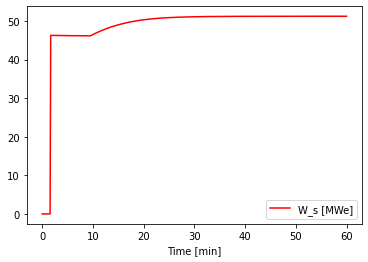

In [42]:
import matplotlib.pyplot as plt
quant.plot(kind='line',x='Time [min]',y='W_s [MWe]',color='red')
plt.show()


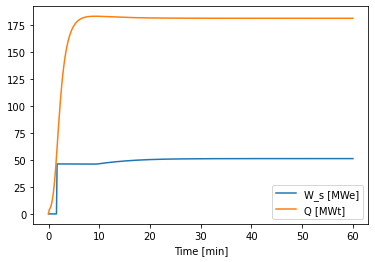

In [43]:
quant.plot(x="Time [min]", y=["W_s [MWe]", "Q [MWt]"], kind="line")

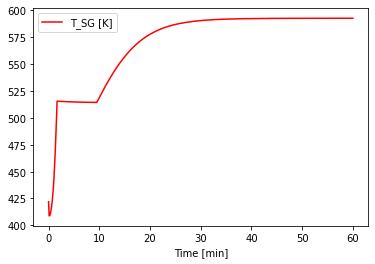

In [44]:

quant.plot(kind='line',x='Time [min]',y='T_SG [K]',color='red')
plt.show()


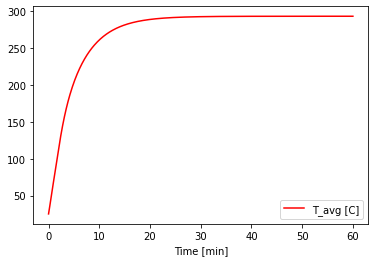

In [45]:
quant.plot(kind='line',x='Time [min]',y='T_avg [C]',color='red')
plt.show()

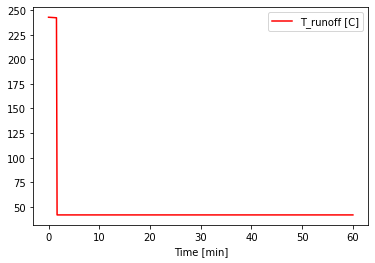

In [46]:
quant.plot(kind='line',x='Time [min]',y='T_runoff [C]',color='red')
plt.show()

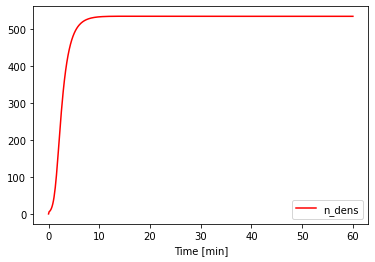

In [47]:
quant.plot(kind='line',x='Time [min]',y='n_dens',color='red')
plt.show()

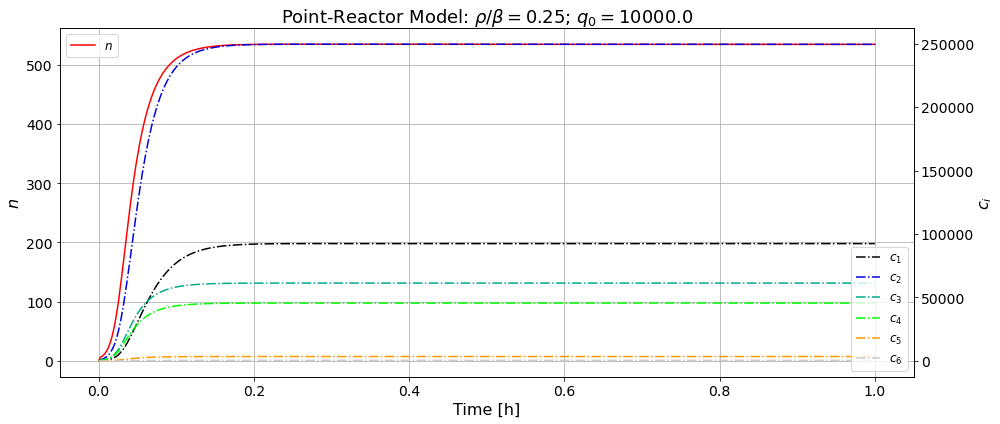

In [33]:
'''Plot neutron and delayed neutron emitter concentration in the reactor'''

plot_results(u_vec_history, normalize=False)

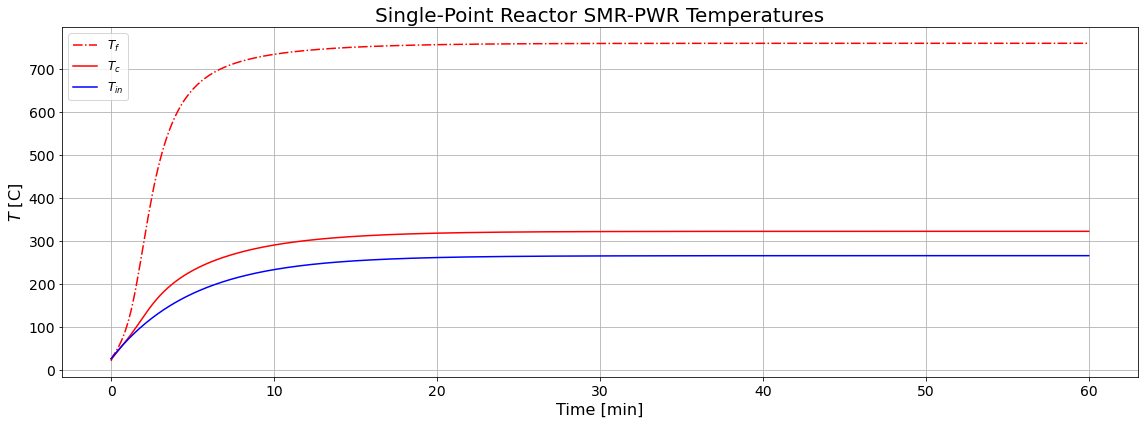

In [34]:
'''Plot Temperatures'''

plot_temperature_results(u_vec_history, quant, params, time_unit='min')

## [References](#toc)

1. Nuclear Reactor Engineering, [Engy-4350](https://github.com/dpploy/engy-4350) UMass Lowell, Dept. Chemical Engineering.